# Pairwise MLP with PU

Train a pairwise MLP model in a pile-up environment.
For a detailed description of the methods refer to the [Master Thesis Text](https://www.merlin.uzh.ch/publication/show/23612).

### Problem setup

This notebook covers the pairwise MLP case, including pre-processing the ROOT files into PyTorch datasets, model training, export into ONNX, and evaluation against the baselines. The reconstruction process consists of the following steps:

### Dataset preprocessing

First the ROOT files are preprocessed into a PyTorch dataset.

#### 1. Select tracksters above a certain energy threshold

Select high energy trackster to run the smoothing around. The energy threshold is a fine-tined parameter, generally, 10 - 50 GeV seems to work well. This notebook covers the pile-up scenario, where simtracksters are only present for selected particle showers in the event. Therefore, only tracksters that have at least 50% energy coming from the examined simtracksters are considered in the training.

**Result**: Selected Tracksters.

#### 2. Get tracksters in cylindrical neighborhood of Selected Tracksters

The cylinder is defined along the axis connecting the trackster barycenter to 0,0,0 and a selected radius (e.g. 15cm). Tracksters withing this radius are considered the Candidate Tracksters. (Selected Trackster, Candidate Trackster) pairs are assigned a truth value using the associator scores.

**Result**: Dataset of Candidate Pairs.

### Model training and inference

The MLP model is trained to solve the following task: given a Candidate Pair, decide whether the two tracksters should be connected. The model is learning to predict the product of RecoToSim associator scores of the pair. Quality Focal Loss function is used to assess the prediction performance.

### Event reconstruction

For each Trackster Candidate, we chose the Selected Trackster with the highest predicted score (likelihood).

#### Evaluation

The improvement in the event reconstruction is evaluated using B-CUBED metrics and compared against the baselines.

## Data location

Set `ds_name` to the dataset name, and point `raw_dir` to the directory containing ntuplized `.root` files.
Processed `PyTorch` datasets will be placed in the `data_root` folder. The program will verify if the requested datasets exist already. Make sure the directories exist.

In [1]:
ds_name = "CloseByPion200PU"
raw_dir = "/home/ecuba/data/CloseByPion200PU"
data_root = "/home/ecuba/data/processed"
model_dir = "/home/ecuba/data/models"

## Initialization

In [2]:
import torch
import torch.nn as nn
import torch.onnx

import numpy as np
import onnxruntime

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import random_split, DataLoader

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from reco.loss import QualityFocalLoss
from reco.dataset_pair import TracksterPairs
from reco.training import train_mlp, roc_auc, precision_recall_curve

In [3]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load or process the dataset

At least `N_FILES=100` root files is recommended to have a large enough training sample.
The following parameters need to be set:
- `bigT_e_th`: energy threshold to select tracksters for smoothing
- `radius`: radius of the cylinder around the selected tracksters
- `pileup`: needs to be set to `true` for pile-up datasets, the selection of the tracksters is limited to ones that overlap with a simtrackster

The following cell will load (if available) or preprocess the root files into a PyTorch dataset. See the class `TracksterPairs` for more details.

In [6]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=400,
    radius=15,
    bigT_e_th=10,
)

ds[0][0]
ds.x.shape

torch.Size([466196, 63])

## Split the dataset into train and validation

In [7]:
decision_threshold = 0.7

print(ds.x.shape)
print("Positive:", int((ds.y >= decision_threshold).type(torch.int).sum()))
print("Negative:", int((ds.y < decision_threshold).type(torch.int).sum()))

balance =  float(sum(ds.y > decision_threshold) / len(ds.y))
print(f"dataset balance: {balance*100:.2f}% / {(1-balance)*100:.2f}%") 

torch.Size([466196, 63])
Positive: 160290
Negative: 305906
dataset balance: 34.38% / 65.62%


In [8]:
# Fraction of the pairs to be left for validation
val_set_fraction = 0.1

ds_size = len(ds)
val_set_size = ds_size // int(1. / val_set_fraction)
train_set_size = ds_size - val_set_size
train_set, val_set = random_split(ds, [train_set_size, val_set_size])
print(f"Train samples: {len(train_set)}, Validation samples: {len(val_set)}")

train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
val_dl = DataLoader(val_set, batch_size=32, shuffle=True)

Train samples: 419577, Validation samples: 46619


## Model configuration

Configure model and training setup.

In [9]:
epochs = 101

hdim1 = 256
hdim2 = 128

dropout_pr = 0.2

In [10]:
model = nn.Sequential(
    nn.LayerNorm(ds.x.shape[1]),      # normalization as a part of the network
    nn.Linear(ds.x.shape[1], hdim1),
    nn.Sigmoid(),
    nn.Linear(hdim1, hdim2),
    nn.Sigmoid(),
    nn.Linear(hdim2, 1),
    nn.Dropout(p=dropout_pr),
)
model = model.to(device)
model_path = f"{model_dir}/PairWiseMLP.PU.{hdim1}.{hdim2}.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)
loss_obj = QualityFocalLoss(gamma=2)

## Training

In [ ]:
#%%script echo skipping

for epoch in range(epochs):
    loss = train_mlp(model, device, optimizer, train_dl, loss_obj)
    train_auc = roc_auc(model, device, train_dl)
    val_auc = roc_auc(model, device, val_dl)
    scheduler.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train auc: {train_auc:.4f}, val auc: {val_auc:.4f}')

torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

In [54]:
roc_auc(model, device, val_dl)

0.9461880700226778

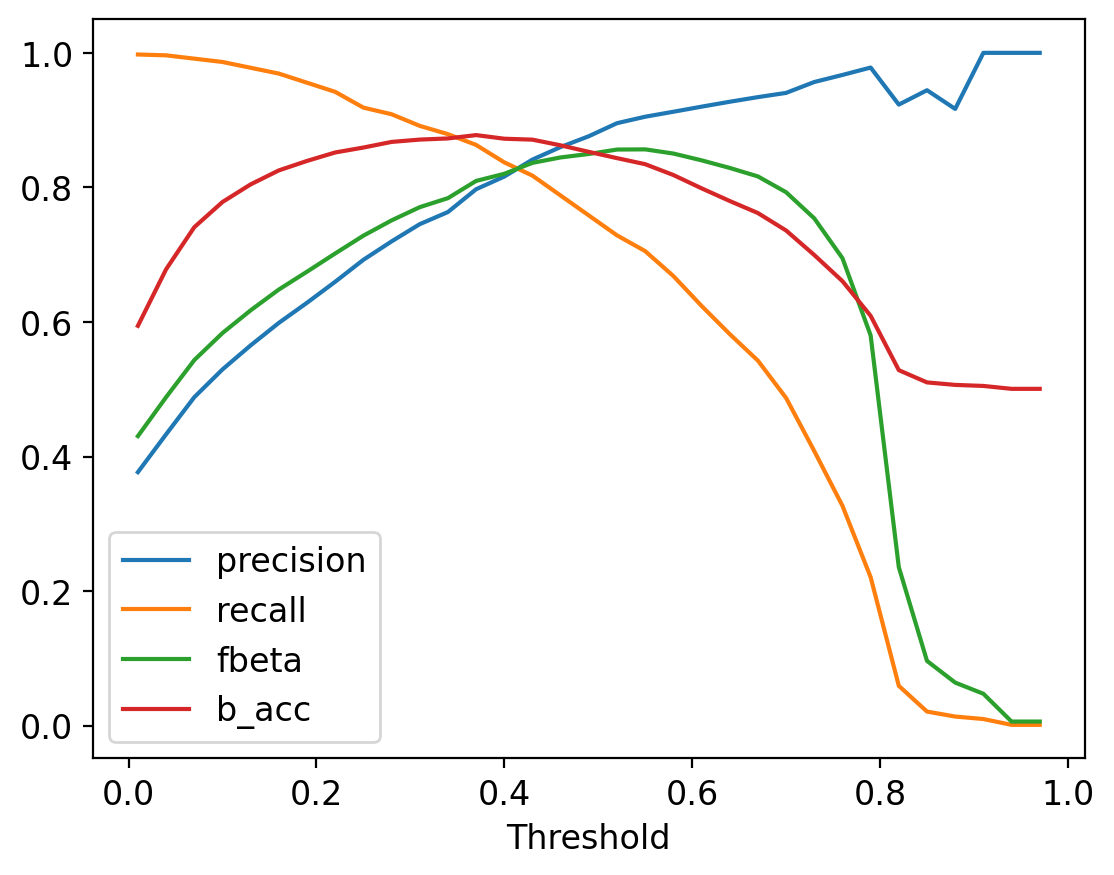

TP: 572, TN: 1594, FP: 60, FN: 239
TH: 0.55 precision: 0.905 recall: 0.705 fbeta: 0.857 b_acc: 0.835


In [55]:
precision_recall_curve(model, device, val_dl, step=3)

# ONNX export

Export the trained model into ONNX and verify the output.

In [56]:
onnx_filepath = f"{model_dir}/PairWiseMLP.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.N_FILES}f.onnx"

torch.onnx.export(
    model,                      # model to be exported
    ds[0][0].reshape(1, -1),    # example input (add batch dimension)
    onnx_filepath,
    export_params=True,
    opset_version=10,
    do_constant_folding=True,
    input_names=['features'],      # the model's input names
    output_names=['output'],    # the model's output names
    dynamic_axes={              # variable length axes
        'features' : {0 : 'batch_size'},    
        'output' : {0 : 'batch_size'}
    }
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [57]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_session = onnxruntime.InferenceSession(onnx_filepath)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(ds[:16][0])}
ort_outs = ort_session.run(None, ort_inputs)
torch_out = model(ds[:16][0])
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


## Evaluation

On a sample of unseen events, evaluate whether the model reached the target (learned to predict the probability of the trackster pair coming from the same SimTrackster), considering increasing radius. Additionally, the output is compared to the naive baseline connecting to all tracksters within the neighborhood.

In [58]:
from reco.data import get_event_data
from reco.evaluation import model_evaluation
from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/test/test_samples_1.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name, pileup=True)

In [59]:
r_ranges = [3, 5, 10, 15]
results = []

max_events = 10
clue3D_F = []
target_F = []
naive_reco_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        DummyPleaser(),
        decision_th=decision_threshold,
        radius=r,
        max_events=max_events,
        bigT_e_th=10,
        pileup=True
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    naive_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model.to("cpu"),
        decision_th=decision_threshold,
        radius=r,
        max_events=max_events,
        bigT_e_th=10,
        pileup=True
    )
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 3 ---
Event 0:
	clue3d_to_sim:	P: 0.878 R: 0.463 F: 0.745
	target_to_sim:	P: 0.881 R: 0.513 F: 0.771
	reco_to_sim:	P: 0.839 R: 0.513 F: 0.744
	|S| = 1 |T| = 1 |R| = 1
Event 1:
	clue3d_to_sim:	P: 0.778 R: 0.005 F: 0.024
	target_to_sim:	P: 0.768 R: 0.006 F: 0.031
	reco_to_sim:	P: 0.615 R: 0.007 F: 0.033
	|S| = 1 |T| = 3 |R| = 3
Event 2:
	clue3d_to_sim:	P: 0.982 R: 0.871 F: 0.958
	target_to_sim:	P: 0.982 R: 0.881 F: 0.960
	reco_to_sim:	P: 0.982 R: 0.881 F: 0.960
	|S| = 1 |T| = 1 |R| = 1
Event 3:
	No data
Event 4:
	clue3d_to_sim:	P: 0.981 R: 0.637 F: 0.885
	target_to_sim:	P: 0.982 R: 0.748 F: 0.924
	reco_to_sim:	P: 0.982 R: 0.748 F: 0.924
	|S| = 1 |T| = 1 |R| = 1
Event 5:
	No data
Event 6:
	clue3d_to_sim:	P: 0.997 R: 0.569 F: 0.867
	target_to_sim:	P: 0.998 R: 0.607 F: 0.884
	reco_to_sim:	P: 0.998 R: 0.607 F: 0.884
	|S| = 1 |T| = 1 |R| = 1
Event 7:
	clue3d_to_sim:	P: 0.852 R: 0.158 F: 0.454
	target_to_sim:	P: 0.845 R: 0.162 F: 0.458
	reco_to_sim:	P: 0.845 R: 0.162 F: 

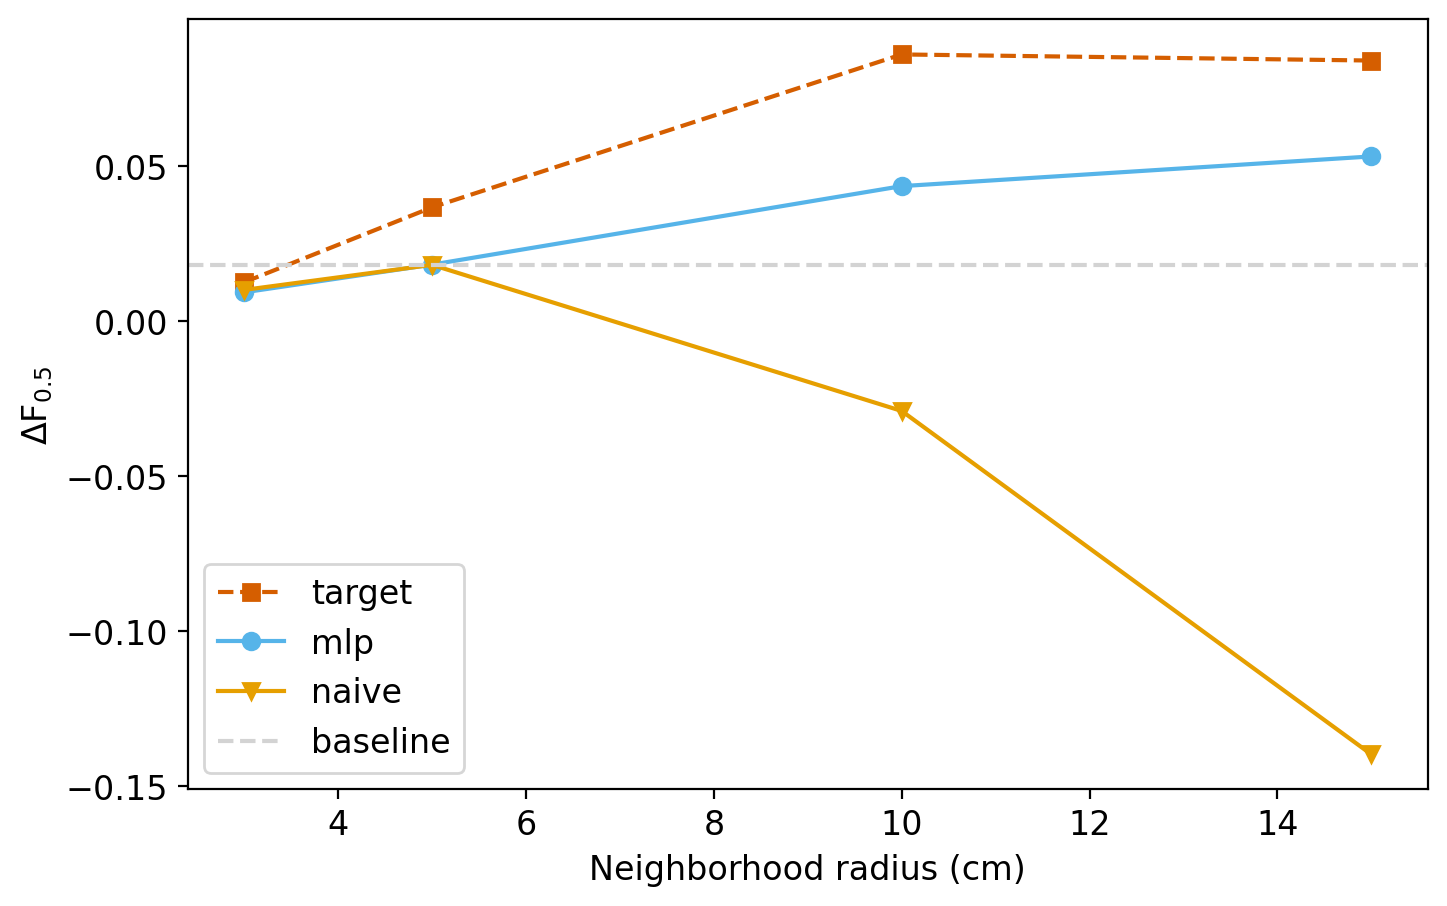

In [60]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="mlp", c="#56B4E9")
ax.plot(r_ranges[:6], (np.array(naive_reco_F) - np.array(clue3D_F))[:6], '-v', label="naive", c="#E69F00")
ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")
plt.show()